In [3]:
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from PIL import Image, ImageOps
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, ndcg_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from PIL import Image, ImageOps
import plotly.graph_objects as go

In [4]:
df = pd.read_csv("NCAA Champion RawData.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Bracket Region', 'Bracket Region/Season', 'sum_coach_mmt_games_played', 'sum_coach_seasons_current_school', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'top_6_AdjEM', 'round_make', 'champion_share', 'make_tournament', 'seed_tournament', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'top_4_seed', 'sum_conf_L1S_cs', 'sum_conf_L3S_cs', 'sum_conf_L5S_cs', 'sum_conf_L8S_cs', 'sum_school_L1S_cs', 'sum_school_L3S_cs', 'sum_school_L5S_cs', 'sum_school_L8S_cs', 'sum_school_champion', 'sum_school_finals_apps', 'sum_school_F4_apps', 'sum_school_E8_apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', '

In [5]:
data_columns = ['sum_coach_mmt_games_played', 'sum_coach_seasons_current_school', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'top_6_AdjEM','champion_share', 
                'seed_tournament', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'top_4_seed', 'sum_conf_L1S_cs', 'sum_conf_L3S_cs', 'sum_conf_L5S_cs', 
                'sum_conf_L8S_cs', 'sum_school_L1S_cs', 'sum_school_L3S_cs', 'sum_school_L5S_cs', 'sum_school_L8S_cs', 'sum_school_champion', 'sum_school_finals_apps', 
                'sum_school_F4_apps', 'sum_school_E8_apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg',
                'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 
                'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 
                'APG', 'SPG', 'BPG', 'TOV', 'PF', 'sum_mm_tour_games', 'AP_top_12_wk_6', 'num_polls_missed', 'sum_polls_made', 'poll_Pre_1', 'poll_Week_2',
                'poll_Week_3', 'poll_Week_4', 'poll_Week_5', 'poll_Week_6', 'poll_Week_7', 'poll_Week_8', 'poll_Week_9', 'poll_Week_10', 'poll_Week _11',
                'poll_Week_12', 'poll_Week_13', 'poll_Week_14', 'poll_Week_15', 'poll_Week_16', 'poll_Week_17', 'poll_Week_18', 'poll_average', 'team_rating_custom', 'max_player_rating_custom', 'cf_rating_custom', 'bracket_region_rating_custom']

df = df.dropna(subset=data_columns)
data = df[data_columns].copy()

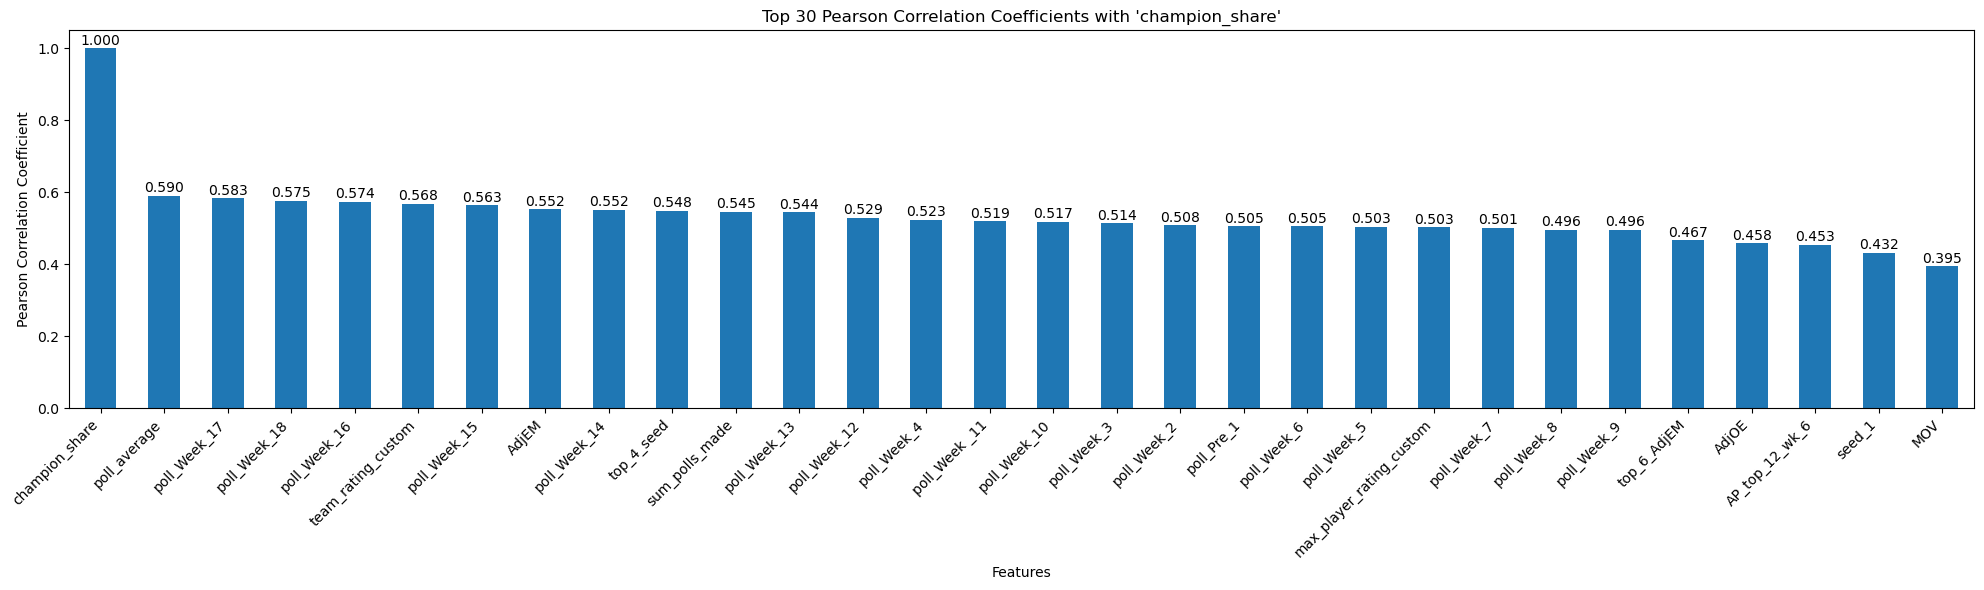

In [34]:

correlations = df[data_columns].corrwith(df['champion_share'])
correlations = correlations.sort_values(ascending=False)

top_correlations = correlations[:30]

plt.figure(figsize=(20, 6))
top_correlations.plot(kind='bar')
plt.title("Top 30 Pearson Correlation Coefficients with 'champion_share'")
plt.xlabel("Features")
plt.ylabel("Pearson Correlation Coefficient")
plt.xticks(rotation=45, ha='right')

for i, val in enumerate(top_correlations):
    plt.text(i, val + 0.01, f'{val:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [35]:
correlation_matrix = data.corr()

correlation_threshold = .7

columns_to_remove = set()
#print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                #print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

In [36]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'sum_coach_mmt_games_played', 'sum_coach_seasons_current_school', 'AdjTempo', 'AdjOE', 'AdjDE', 'top_6_AdjEM', 'champion_share', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'top_4_seed', 'sum_conf_L1S_cs', 'sum_school_L1S_cs', 'sum_school_champion', 'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'FIC40', 'DRtg', 'eDiff', 'Poss', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', 'High Game', 'Techs', 'FT/FGA', 'W's', 'MPG', '3PM', '3P%', 'FT%', 'DRB', 'PF', 'sum_mm_tour_games', 'AP_top_12_wk_6', 'num_polls_missed', 'poll_Pre_1', 'max_player_rating_custom', 'cf_rating_custom', 'bracket_region_rating_custom'

Columns that were removed:
'Total S%', 'poll_Week _11', 'Win %', 'sum_conf_L5S_cs', 'FGA', 'seed_tournament', 'poll_Week_10', 'sum_conf_L3S_cs', 'AdjEM', 'TOV', 'poll_Week_14', 'FTA', 'poll_Week_4', 'poll_Week_16', 'sum_school_finals_apps', '5 Blk', 'Pace', 'L's', 'RPG', 'sum_school_F4_apps', 'FG%', 'poll_Week_5', 'sum_school_L3S_cs', 

In [6]:
features = ['AdjTempo', 'top_6_AdjEM',
            'top_4_seed', 'sum_conf_L1S_cs', 'sum_school_L1S_cs', 'team_rating_custom',
            'sum_school_champion', 'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'FIC40', 'DRtg', 'eDiff',
            'Poss', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', 'High Game', 'Techs', 'FT/FGA', 'MPG', '3PM',
            '3P%', 'FT%', 'DRB', 'PF', 'sum_mm_tour_games', 'AP_top_12_wk_6', 'num_polls_missed', 'poll_Pre_1', 'max_player_rating_custom', 'bracket_region_rating_custom']


            
num_features = len(features)

print(f"Number of features: {num_features}")


Number of features: 40


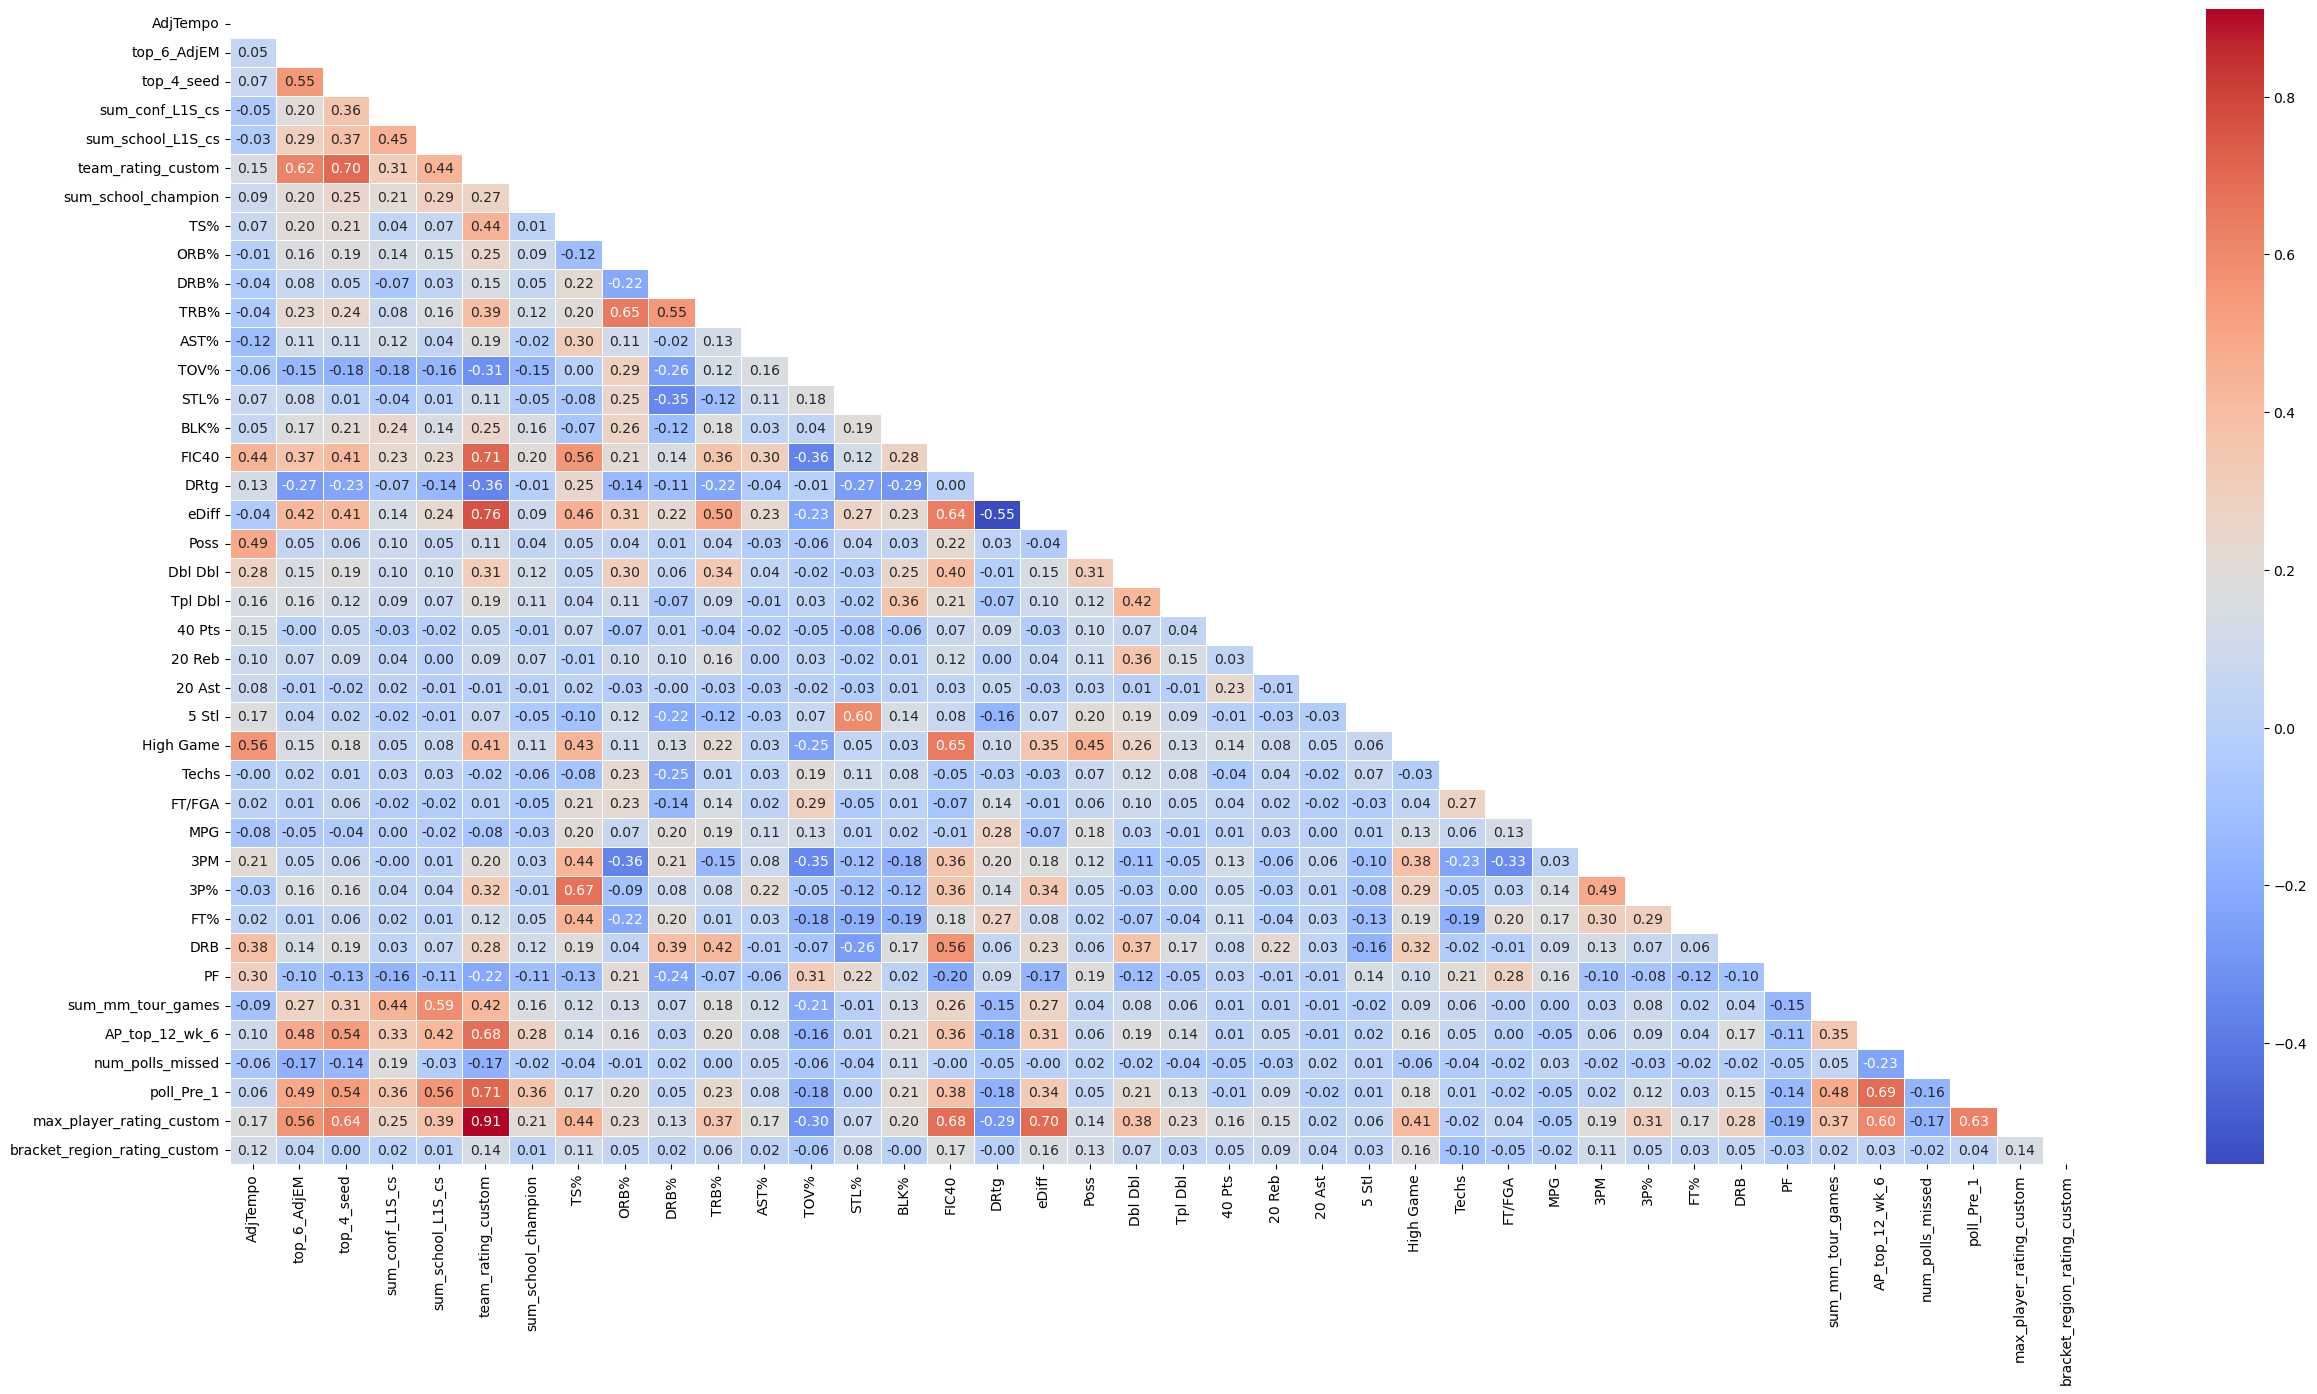

In [7]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

## Ridge Regression:

Results:

    Season            Team  champion_share  predicted_cs
0     2024           Uconn        1.000000      0.619941
10    2024         Houston        0.333333      0.583809
1     2024          Purdue        0.833333      0.504161
9     2024         Arizona        0.333333      0.484982
26    2024          Kansas        0.166667      0.465346
5     2024            Duke        0.500000      0.429206
13    2024       Marquette        0.333333      0.418677
15    2024      Iowa State        0.333333      0.417196
11    2024  North Carolina        0.333333      0.397161
4     2024       Tennessee        0.500000      0.373808
35    2024          Auburn        0.000000      0.373302
12    2024       Creighton        0.333333      0.370634
24    2024          Baylor        0.166667      0.358189
46    2024        Kentucky        0.000000      0.313644
-----------------------------------------------------------------------------

NDCG Scores: 

True NDCG @:  0.9260546895572176
--------

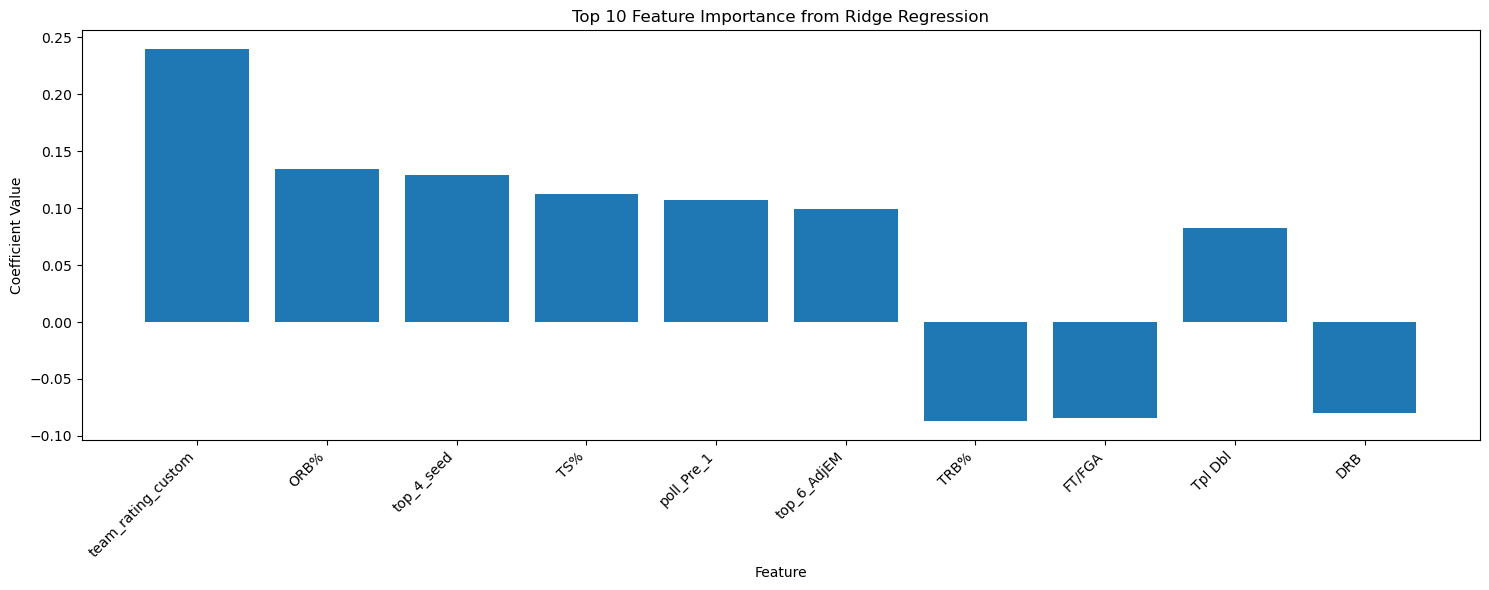

In [9]:

train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

rig = Ridge(alpha=0.5)
rig.fit(train[features], train["champion_share"])

predictions = rig.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(14))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=14):
    true_relevance = df['champion_share'].values
    return ndcg_at_k(true_relevance, k=16)

ndcg_score_true = calculate_ndcg(frame, k=16)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

coefficients = rig.coef_
feature_coefficients = dict(zip(features, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

top_features = sorted_feature_coefficients[:10]
features_names = [x[0] for x in top_features]
coeff_values = [x[1] for x in top_features]

plt.figure(figsize=(15, 6))
plt.bar(features_names, coeff_values)
plt.title('Top 10 Feature Importance from Ridge Regression')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

predictions = rig.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
rig_reg_frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
rig_reg_frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

In [68]:
actual = frame.sort_values("champion_share", ascending=False)
predicted = frame.sort_values("predicted_cs", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame):
    actual = frame.sort_values("champion_share", ascending=False).head(1) #HEAD

    predicted = frame.sort_values("predicted_cs", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame)
print("=============================================================================\n")
print("AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x   Team  champion_share_x  predicted_cs_x  Rank  Season_y  champion_share_y  predicted_cs_y  Predicted Rank
0      2024  Uconn               1.0        0.663215     1      2024               1.0        0.663215               1

AP Champion:  1.0


In [76]:
# Initialize the combined predictions DataFrame
rig_reg_combined_predictions = pd.DataFrame(columns=["Season", "Team/Season", "Team", "predicted_cs", "champion_share"])

all_predictions = []
aps = []
ndcgs = []

backtest_seasons = [2024,2023,2022,2021, 2019, 2018,2017, 2016,2014,2013]
#backtest_seasons = [2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rig.fit(train[features], train['champion_share'])
    predictions = rig.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
    frame = pd.concat([test[["Team", "champion_share", "Season"]], predictions_df], axis=1)

    frame['Team/Season'] = frame['Team'] + ' ' + frame['Season'].astype(str)

    # Append the predictions for the current season to the combined predictions DataFrame
    rig_reg_combined_predictions = pd.concat([rig_reg_combined_predictions, frame], ignore_index=True)

    if not frame.empty:
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["champion_share"].values.reshape(1, -1), predictions.reshape(1, -1))
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted_cs", ascending=False).head(10)

    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted_cs", "champion_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_ndcg = 1.0 / average_ndcg

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(reciprocal_ndcg, 2)}")
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

rig_reg_combined_predictions.to_csv("rig_reg_ncaa_preds.csv", index=False)

Champion AP for Season 2024: 1.0 | Reciprocal: 1.0 | NDCG: 0.9
Champion AP for Season 2023: 0.33 | Reciprocal: 3.0 | NDCG: 0.77
Champion AP for Season 2022: 0.5 | Reciprocal: 2.0 | NDCG: 0.8
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0 | NDCG: 0.87
Champion AP for Season 2019: 0.25 | Reciprocal: 4.0 | NDCG: 0.85
Champion AP for Season 2018: 1.0 | Reciprocal: 1.0 | NDCG: 0.84
Champion AP for Season 2017: 0.5 | Reciprocal: 2.0 | NDCG: 0.8
Champion AP for Season 2016: 0.2 | Reciprocal: 5.0 | NDCG: 0.88
Champion AP for Season 2014: 0.04 | Reciprocal: 26.0 | NDCG: 0.74
Champion AP for Season 2013: 1.0 | Reciprocal: 1.0 | NDCG: 0.9

Top 5 Predicted Teams for Season 2024:
              Team  predicted_cs  champion_share
0            Uconn      0.619941        1.000000
10         Houston      0.583809        0.333333
1           Purdue      0.504161        0.833333
9          Arizona      0.484982        0.333333
26          Kansas      0.465346        0.166667
5             Duke      0.

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


## Analyzing Model Decision Making:

Top 10 Features:
['top_4_seed', 'team_rating_custom', 'poll_Pre_1', 'num_polls_missed', 'ORB%', 'top_6_AdjEM', 'TOV%', 'FT/FGA', 'sum_school_champion', 'sum_school_L1S_cs']


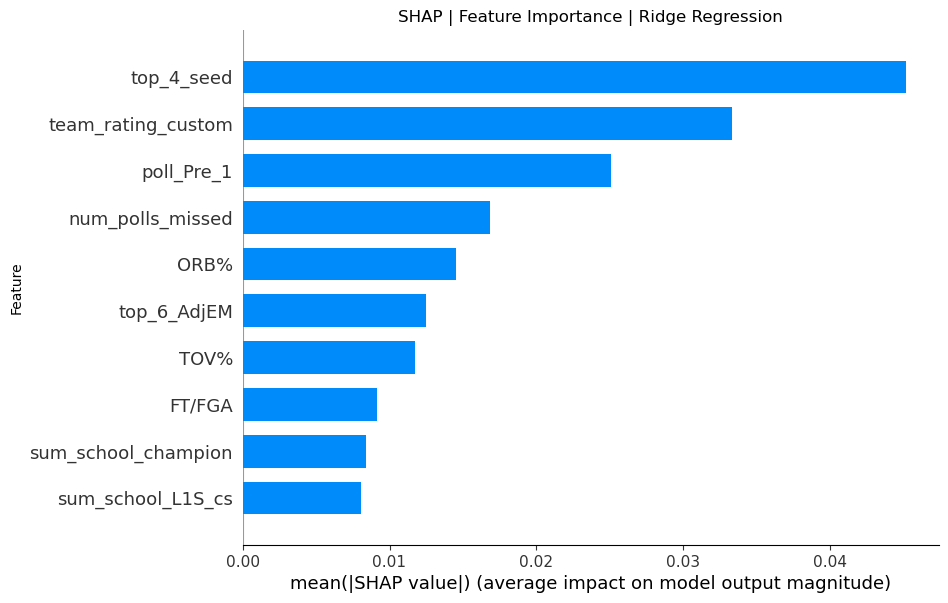

In [35]:
explainer = shap.LinearExplainer(rig, train[features])
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)
plt.title('SHAP | Feature Importance | Ridge Regression')

plt.savefig("ridge_shap_bar.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ridge_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ridge_shap_bar.png")

plt.ylabel("Feature")
plt.show()

Top 10 Features:
['top_4_seed', 'team_rating_custom', 'poll_Pre_1', 'num_polls_missed', 'ORB%', 'top_6_AdjEM', 'TOV%', 'FT/FGA', 'sum_school_champion', 'sum_school_L1S_cs']


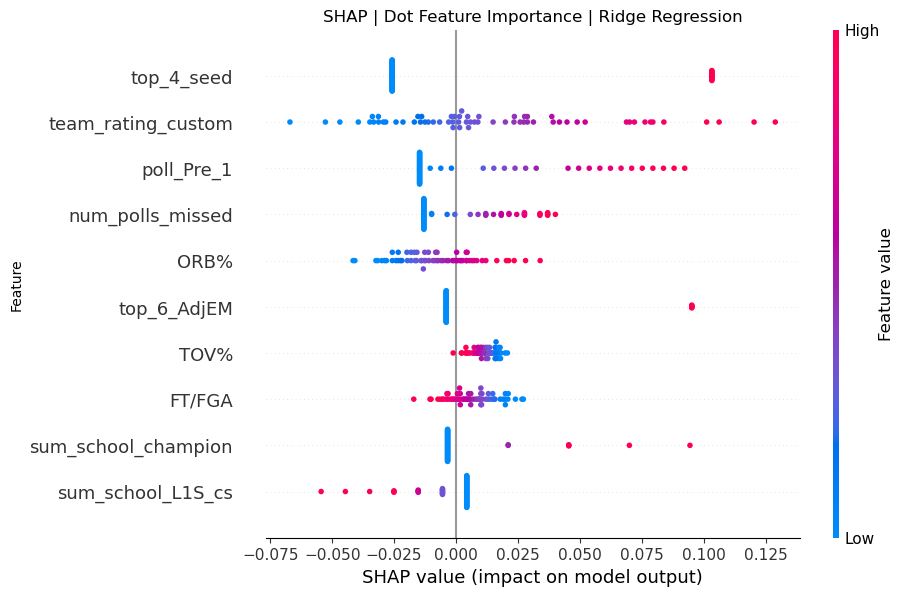

In [36]:

explainer = shap.LinearExplainer(rig, train[features])
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | Ridge Regression')

plt.savefig("rig_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rig_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rig_shap_dot.png")

plt.ylabel("Feature")
plt.show()

## Random-Forest Regression:

In [21]:
df = pd.read_csv("NCAA Champion RawData.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Bracket Region', 'Bracket Region/Season', 'sum_coach_mmt_games_played', 'sum_coach_seasons_current_school', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'top_6_AdjEM', 'round_make', 'champion_share', 'make_tournament', 'seed_tournament', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'top_4_seed', 'sum_conf_L1S_cs', 'sum_conf_L3S_cs', 'sum_conf_L5S_cs', 'sum_conf_L8S_cs', 'sum_school_L1S_cs', 'sum_school_L3S_cs', 'sum_school_L5S_cs', 'sum_school_L8S_cs', 'sum_school_champion', 'sum_school_finals_apps', 'sum_school_F4_apps', 'sum_school_E8_apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', '

In [22]:
data_columns = ['sum_coach_mmt_games_played', 'sum_coach_seasons_current_school', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'top_6_AdjEM','champion_share', 
                'seed_tournament', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'top_4_seed', 'sum_conf_L1S_cs', 'sum_conf_L3S_cs', 'sum_conf_L5S_cs', 
                'sum_conf_L8S_cs', 'sum_school_L1S_cs', 'sum_school_L3S_cs', 'sum_school_L5S_cs', 'sum_school_L8S_cs', 'sum_school_champion', 'sum_school_finals_apps', 
                'sum_school_F4_apps', 'sum_school_E8_apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg',
                'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 
                'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 
                'APG', 'SPG', 'BPG', 'TOV', 'PF', 'sum_mm_tour_games', 'AP_top_12_wk_6', 'num_polls_missed', 'sum_polls_made', 'poll_Pre_1', 'poll_Week_2',
                'poll_Week_3', 'poll_Week_4', 'poll_Week_5', 'poll_Week_6', 'poll_Week_7', 'poll_Week_8', 'poll_Week_9', 'poll_Week_10', 'poll_Week _11',
                'poll_Week_12', 'poll_Week_13', 'poll_Week_14', 'poll_Week_15', 'poll_Week_16', 'poll_Week_17', 'poll_Week_18', 'poll_average', 'team_rating_custom', 'max_player_rating_custom', 'cf_rating_custom', 'bracket_region_rating_custom']

df = df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [23]:
correlation_matrix = data.corr()

correlation_threshold = .6

columns_to_remove = set()
#print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                #print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'sum_coach_mmt_games_played', 'sum_coach_seasons_current_school', 'AdjTempo', 'AdjOE', 'AdjDE', 'top_6_AdjEM', 'champion_share', 'seed_2', 'seed_3', 'seed_4', 'top_4_seed', 'sum_conf_L1S_cs', 'sum_school_L1S_cs', 'sum_school_champion', 'TS%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'eDiff', 'Poss', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', 'High Game', 'Techs', 'FT/FGA', 'MPG', '3PM', 'FT%', 'DRB', 'PF', 'sum_mm_tour_games', 'AP_top_12_wk_6', 'num_polls_missed', 'bracket_region_rating_custom'

Columns that were removed:
'5 Blk', 'Ast/TO', 'FIC40', 'poll_Week_10', 'sum_school_L3S_cs', 'TOV', 'Pace', 'L's', 'MOV', 'Stl/TO', 'poll_Pre_1', 'FTM', 'FGM', 'FGA', 'eFG%', 'poll_Week_3', 'FTA', 'sum_conf_L8S_cs', 'poll_Week_13', 'poll_Week_16', 'GP', 'sum_conf_L3S_cs', 'poll_Week _11', 'W's', 'seed_tournament', 'poll_Week_15', 'PPS', 'sum_school_L5S_cs', 'poll_Week_4', 'BPG', 'poll_Week_2', 'sum_school_E8_apps', 'sum_polls_made', 'DRtg', 'pol

In [28]:
features = ['max_player_rating_custom', 'cf_rating_custom', 'poll_Week_8', 'top_6_AdjEM',
            'AdjTempo', 'AdjOE', 'AdjDE', 'team_rating_custom', 
            'sum_conf_L1S_cs', 'sum_school_L1S_cs', 'sum_school_champion', 
            
            'TS%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'eDiff', 'Poss', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', 'High Game',
            'Techs', 'FT/FGA', 'MPG', '3PM', 'FT%', 'DRB', 'PF', 
            
            
            'sum_mm_tour_games', 'AP_top_12_wk_6', 'num_polls_missed', 'bracket_region_rating_custom']


            
num_features = len(features)

print(f"Number of features: {num_features}")


Number of features: 38


Results:

    Season            Team  champion_share  predicted_cs
0     2024           Uconn        1.000000      0.646010
9     2024         Arizona        0.333333      0.585317
10    2024         Houston        0.333333      0.581859
1     2024          Purdue        0.833333      0.553668
11    2024  North Carolina        0.333333      0.390986
4     2024       Tennessee        0.500000      0.372230
35    2024          Auburn        0.000000      0.366860
53    2024       Wisconsin        0.000000      0.340091
8     2024         Gonzaga        0.333333      0.326663
12    2024       Creighton        0.333333      0.325397
-----------------------------------------------------------------------------

NDCG Scores: 

True NDCG @:  0.9309118096501569
-----------------------------------------------------------------------------



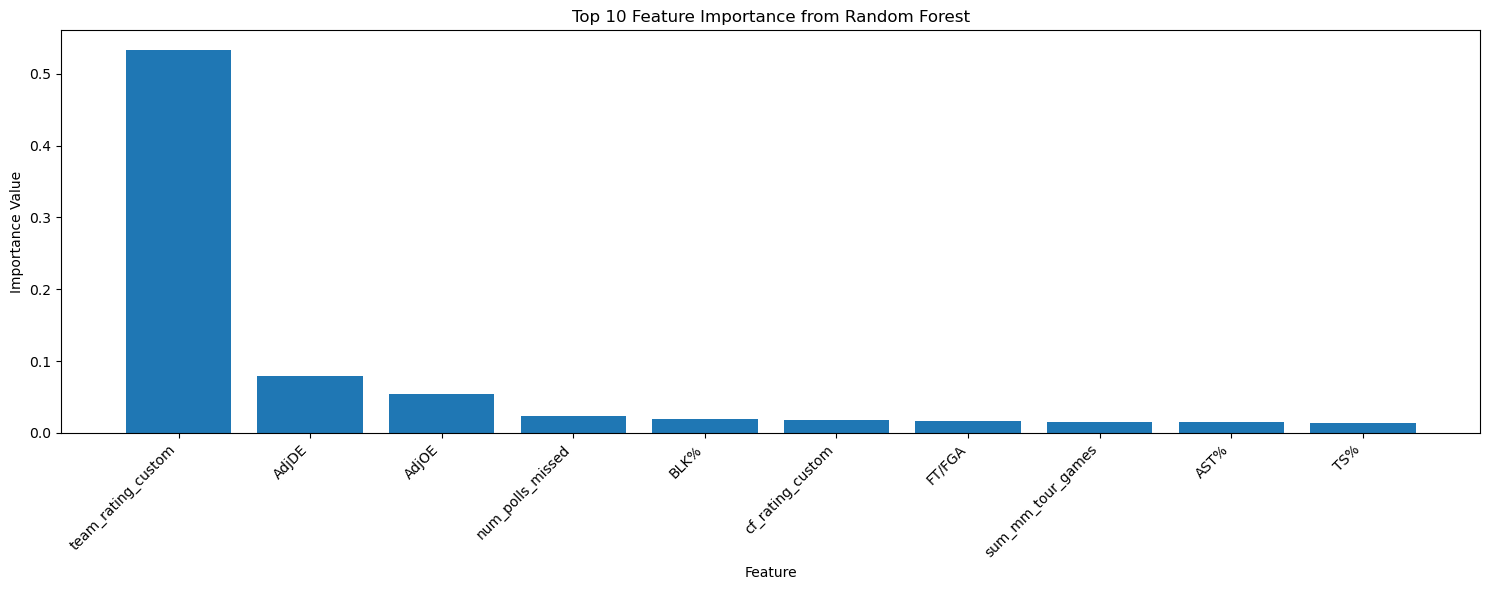

In [29]:
df.drop(df[df['Season'] < 2005].index, inplace = True)

train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

rf = RandomForestRegressor(n_estimators=30, random_state=5, min_samples_split=3, max_depth=5)
rf.fit(train[features], train["champion_share"])

predictions = rf.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(10))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=14):
    true_relevance = df['champion_share'].values
    return ndcg_at_k(true_relevance, k)

ndcg_score_true = calculate_ndcg(frame, k=14)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

feature_importances = rf.feature_importances_
feature_importance_dict = dict(zip(features, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_features = sorted_feature_importance[:10]
features_names = [x[0] for x in top_features]
importances = [x[1] for x in top_features]

plt.figure(figsize=(15, 6))
plt.bar(features_names, importances)
plt.title('Top 10 Feature Importance from Random Forest')
plt.ylabel('Importance Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

predictions = rf.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
rf_reg_frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
rf_reg_frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

In [26]:
actual = frame.sort_values("champion_share", ascending=False)
predicted = frame.sort_values("predicted_cs", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

def find_ap(frame):
    actual = frame.sort_values("champion_share", ascending=False).head(1) #HEAD

    predicted = frame.sort_values("predicted_cs", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame)
print("=============================================================================\n")
print("AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x   Team  champion_share_x  predicted_cs_x  Rank  Season_y  champion_share_y  predicted_cs_y  Predicted Rank
0      2024  Uconn               1.0         0.61074     1      2024               1.0         0.61074               1

AP Champion:  1.0


In [30]:

rf_reg_combined_predictions = pd.DataFrame(columns=["Season", "Team/Season", "Team", "predicted_cs", "champion_share"])

all_predictions = []
aps = []
ndcgs = []

backtest_seasons = [2024,2023,2022,2021, 2019, 2018,2017, 2016,2014,2013]
#backtest_seasons = [2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion_share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
    frame = pd.concat([test[["Team", "champion_share", "Season"]], predictions_df], axis=1)

    frame['Team/Season'] = frame['Team'] + ' ' + frame['Season'].astype(str)

    rf_reg_combined_predictions = pd.concat([rf_reg_combined_predictions, frame], ignore_index=True)

    if not frame.empty:
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["champion_share"].values.reshape(1, -1), predictions.reshape(1, -1))
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted_cs", ascending=False).head(10)

    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted_cs", "champion_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_ndcg = 1.0 / average_ndcg

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(reciprocal_ndcg, 2)}")
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

rf_reg_combined_predictions.to_csv("rf_reg_ncaa_preds.csv", index=False)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2024: 1.0 | Reciprocal: 1.0 | NDCG: 0.89
Champion AP for Season 2023: 0.17 | Reciprocal: 6.0 | NDCG: 0.75
Champion AP for Season 2022: 0.14 | Reciprocal: 7.0 | NDCG: 0.78
Champion AP for Season 2021: 0.5 | Reciprocal: 2.0 | NDCG: 0.88
Champion AP for Season 2019: 0.33 | Reciprocal: 3.0 | NDCG: 0.85
Champion AP for Season 2018: 0.5 | Reciprocal: 2.0 | NDCG: 0.79
Champion AP for Season 2017: 0.25 | Reciprocal: 4.0 | NDCG: 0.82
Champion AP for Season 2016: 0.17 | Reciprocal: 6.0 | NDCG: 0.81
Champion AP for Season 2014: 0.05 | Reciprocal: 22.0 | NDCG: 0.75
Champion AP for Season 2013: 0.17 | Reciprocal: 6.0 | NDCG: 0.76

Top 5 Predicted Teams for Season 2024:
              Team  predicted_cs  champion_share
0            Uconn      0.646010        1.000000
9          Arizona      0.585317        0.333333
10         Houston      0.581859        0.333333
1           Purdue      0.553668        0.833333
11  North Carolina      0.390986        0.333333
4        Tennessee